# КТ-2. Рынок Недвижимости

Анализ рынка недвижимости представляет собой ключевую задачу для понимания динамики цен и факторов, влияющих на стоимость объектов. В рамках данной работы проведена комплексная обработка данных, включая интеграцию информации из дополнительных источников, восстановление пропусков и устранение аномалий. Основной целью исследования является выявление закономерностей ценообразования, определение оптимальных периодов для сделок и создание модели прогноза стоимости недвижимости.

## Вводные <a id="1"></a>

### Интерактивное оглавление <a id="0"></a>

1. [Вводные](#1)
   - 1.1 [Список задач](#11)
   - 1.2 [Описание датасета](#12)
2. [Знакомство с данными](#2)
3. [Предобработка данных](#3)
4. [Выполнение заданий](#4)
   - 4.1 [Добавление информации из region.csv](#41)
   - 4.2 [Восстановление пропусков в столбце kitchen_area](#42)
   - 4.3 [Исследование рынка недвижимости в РФ за представленный период. Обработка аномалий](#43)
   - 4.4 [Выяснение когда выгодно покупать/продавать объект недвижимости](#44)
   - 4.5 [Определение от каких признаков зависит стоимость объекта недвижимости](#45)
   - 4.6 [Выдвижение и проверка собственной гипотезы статистическими методами.](#46)
   - 4.7 [Создание модели прогноза цены объекта недвижимости.](#47)
5. [Вывод](#5)

#### Список задач <a id="11"></a>
1. Познакомиться с данными.
2. Добавить информацию из датасета region.csv.
3. Восстановите пропуски в столбце kitchen_area. 
4. Исследовать рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2. Обработать аномалии.
5. Выяснить когда выгодно покупать/продавать объект недвижимости? 
6. Определить от каких признаков зависит стоимость объекта недвижимости. Найти скрытые закономерности.
7. Выдвинуть и проверить собственную гипотезу статистическими методами.
8. Создать модель прогноза цены объекта недвижимости.

[НАЗАД](#0)

#### Описание датасета realty_18_21.csv <a id="12"></a>
- `date` - дата объявления
- `region` - Регион
- `building_type` - Тип дома
    - 0 - Другое.
    - 1 - Панельный.
    - 2 - Кирпично-монолитный.
    - 3 - Кирпичный.
    -  4 - Блочный
    -  5 - Деревянный
- `object_type` -
    - 1 - Вторичный рынок;
    - 11 - Первичный рынок;
- `level` - Этаж
- `levels` - Число этажей
- `rooms` - Число комнат, где -1 означает студия
- `area` - Общая площадь
- `kitchen_area` - Площадь кухни
- `price` - Цена в руб.

[НАЗАД](#0)

## Знакомство с данными <a id="2"></a> [НАЗАД](#0)

Прежде всего импортируем датасет, библиотеки и компоненты. Ознакомимся с данными. Отметим проблематичные моменты и наметим план предобработки

In [1]:
%pip install cianparser -q
%pip install lightgbm -q
%pip install scikit_posthocs -q

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cianparser
import lightgbm as lgb
import numpy as np
from scipy import stats
from scipy.stats import zscore
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('realty_18_21.csv')
blen = len(df)
df.sample(3)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
3370677,4450000,2020-02-29,2843,2,5,6,5,151.0,15.0,1
459614,2750000,2018-11-11,6171,1,5,9,2,52.0,10.0,1
4232916,3920000,2020-08-04,9654,1,2,10,2,76.0,14.0,1


На первый взгляд все выглядит прилично. Проверю далее типы данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 417.9+ MB


## Предобработка данных <a id="3"></a> [НАЗАД](#0)

Типы данных в порядке. Однако стоит изменить обозначения `object_type` на 1 и 2 для первичного и вторичного рынка соответственно.

In [4]:
df['object_type'] = df['object_type'].replace(1, 2)
df['object_type'] = df['object_type'].replace(11, 1)

Далее разберемся с дубликатами и пропусками.

In [5]:
df.isna().sum()

price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     253711
object_type           0
dtype: int64

In [6]:
print('Пропуски в столбце кухня составляют', df['kitchen_area'].isna().sum() / len(df)*100,'%')

Пропуски в столбце кухня составляют 4.632293629037471 %


4.6% - это очень много. Безболезненно столько строк не удалить, а потому решено их заполнить. Это можно сделать и медианными значениями, но я попробую обучить модель и на основе прочих факторов заполнить пропущенные значения. Но чуть позже :)

In [7]:
print('Дубликаты составляют', df.duplicated().sum() / len(df)*100,'%')

Дубликаты составляют 4.302624463073438 %


Дубликатов 4.3%. От них тоже нельзя избавиться. Давайте посмотрим какого рода эти дубликаты?

In [8]:
duplicated_mask = df.duplicated(keep=False)
duplicates_grouped = df[duplicated_mask].sort_values(by=df.columns.tolist())
duplicates_grouped

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
4426359,-2144967296,2020-09-22,9654,1,1,10,1,33.60,9.0,2
4427261,-2144967296,2020-09-22,9654,1,1,10,1,33.60,9.0,2
1126718,-2114150296,2019-02-12,9654,1,8,10,3,87.39,13.0,1
1128977,-2114150296,2019-02-12,9654,1,8,10,3,87.39,13.0,1
1143642,-2114150296,2019-02-14,9654,1,8,10,3,87.39,13.0,1
...,...,...,...,...,...,...,...,...,...,...
1539866,2083290000,2019-04-04,9654,4,9,10,2,63.00,12.0,2
1556562,2083290000,2019-04-08,9654,4,9,10,2,63.00,12.0,2
1562062,2083290000,2019-04-08,9654,4,9,10,2,63.00,12.0,2
1587590,2083290000,2019-04-11,9654,4,9,10,2,63.00,12.0,2


Учитывая специфику строительства в Советском и пост-советском постранстве, нужно помнить о том, что дома типа 1-464А, И-700А и многие другие - типовые здания. Внутри они имеют частичную симметрию отчего обилие дубликатов - вполне ожидаемое явление. К тому же у нас нет уникальных идентификаторов жилья. Максимально приближенное к этому - цена продажи, но она тоже мало о чем говорит фактически. Сейчас популярны калькуляторы расчета цены недвижимости. Неудивительно, что для квартир с одинаковыми параметрами калькуляторы выдают одинаковую стоимость за которую те потом продаются. Я не буду удалять дубликаты для сохранения полноты исследования, Однако если заказчик посчитает это проблеммой, то наверняка можно найти компромисное решение.

Теперь перейду к обработке "нелогичных значений". Для начала оценю: все ли типовые значения соответствуют заявленным в шапке:

In [9]:
df['building_type'].unique()

array([1, 3, 4, 2, 5, 0], dtype=int64)

In [10]:
df['object_type'].unique()

array([2, 1], dtype=int64)

С этим все в порядке. Теперь оценим строки, где площадь кухни больше площади дома:

In [11]:
df[df['kitchen_area'] > df['area']]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
502,4599000,2018-09-08,9654,3,6,10,2,5.60,7.70,2
673,1350000,2018-09-08,9654,1,5,10,1,13.78,48.02,1
4500,1570000,2018-09-08,1010,3,4,5,1,32.00,65.00,2
5740,1740900,2018-09-09,9654,1,4,10,2,58.03,78.00,1
6055,1350000,2018-09-09,9654,1,5,10,1,13.78,48.02,1
...,...,...,...,...,...,...,...,...,...,...
5392668,36874000,2021-04-24,2661,3,2,4,-2,9.00,19.70,2
5432473,5200000,2021-04-29,81,2,7,17,-2,9.00,10.70,2
5455773,2750000,2021-04-30,9648,4,3,3,2,45.00,45.60,2
5474504,23399000,2021-05-01,2843,2,24,24,-2,9.00,40.00,1


In [12]:
df = df[~(df['kitchen_area'] > df['area'])]

Теперь изучим дома, которые находятся на этаж выше, чем есть в доме и удалим их

In [13]:
df[df['level'] > df['levels']]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
26283,1850000,2018-09-12,3870,3,17,13,1,37.00,10.00,2
35903,1100000,2018-09-13,9654,3,4,1,1,30.00,8.00,2
117969,700000,2018-09-22,2722,3,2,1,2,40.00,11.00,2
148751,3200000,2018-09-27,11171,2,4,3,1,31.00,10.00,2
164863,1050000,2018-09-28,2843,4,2,1,2,54.00,10.00,2
...,...,...,...,...,...,...,...,...,...,...
4942329,4750000,2021-01-19,2843,4,11,10,2,54.00,6.00,2
5175158,6984180,2021-03-18,81,3,4,3,2,57.80,11.68,1
5175162,7164620,2021-03-18,81,3,4,3,2,78.84,11.68,1
5175971,4136487,2021-03-18,81,3,4,3,1,48.40,9.01,1


In [14]:
df = df[~(df['level'] > df['levels'])]

Рассмотрим аномальные значения:

In [15]:
print('Этажи:', df['levels'].max(), '\nПлощадь:', df['area'].max(), '\nПлощадь кухни:', df['kitchen_area'].max())

Этажи: 39 
Площадь: 7856.0 
Площадь кухни: 4949.0


In [16]:
df[df['area'] > 1100]

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
132529,3600000,2018-09-25,3991,0,12,17,2,3600.0,20.0,2
183010,1070000,2018-10-02,4007,3,5,5,2,3800.0,1200.0,2
275294,4444444,2018-10-15,2871,2,4,4,3,4444.0,444.0,2
474818,999000,2018-11-13,2871,3,1,2,2,4180.0,10.0,2
659313,2150000,2018-12-05,2843,3,15,17,1,3366.0,9.0,2
...,...,...,...,...,...,...,...,...,...,...
5383330,26170000,2021-04-23,2661,2,2,8,3,1399.0,20.1,2
5385469,7800000,2021-04-23,4007,3,3,11,3,1400.0,24.0,2
5393688,4500000,2021-04-25,4007,3,4,5,2,5000.0,9.0,2
5424110,2200000,2021-04-27,4189,3,1,3,1,1499.3,8.0,2


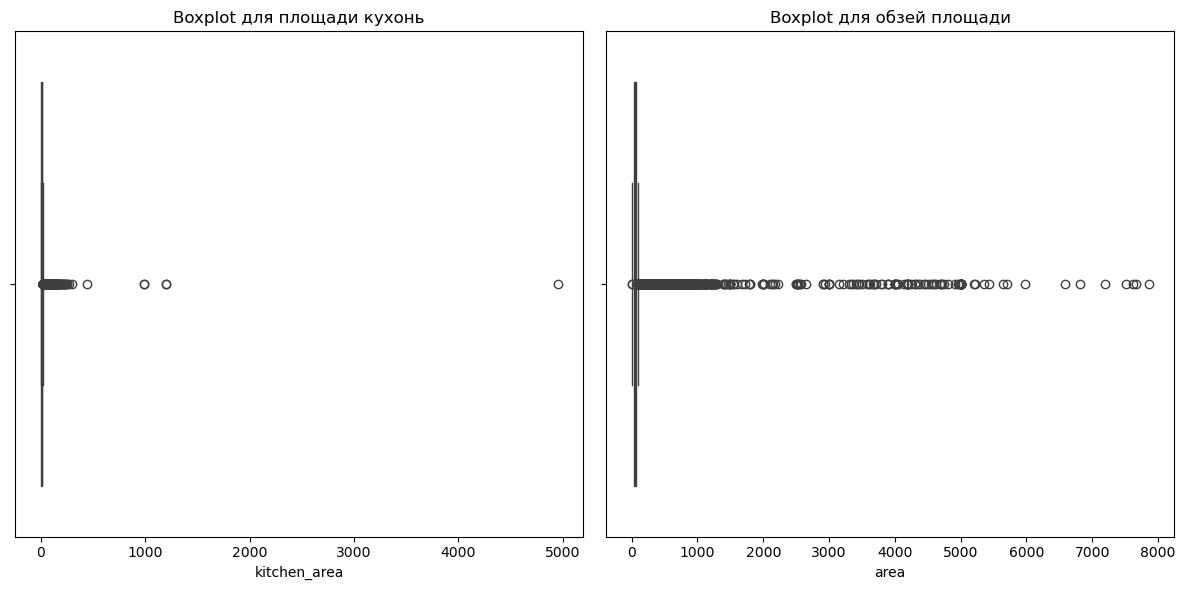

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='kitchen_area')
plt.title('Boxplot для площади кухонь')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='area')
plt.title('Boxplot для обзей площади')

plt.tight_layout()
plt.show()

Получив ящик с усами для выбросов по площадям, мы моглм ы удалить выбросы привычным методом, однако я считаю, что в данной работе это будет не корректно. Я провел анализ рынка недвижимости в России сейчас и в прошлом. В данном случае (поскольку мы не заем намерения заказчика) вприницпе некорректно удалять выбросы по площади кухни (квартиры бывают разные). Выбросы по значению общей площади я удалю, основываясь на реальных данных о недвижимости в россии для каждого типа построек.

Однако, имеет смысл удалить такие дома, которые не являются квартирами-студиями, но кухня занимает всю жилую площадь.

In [18]:
df.query('rooms !=-1 and kitchen_area == area')

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
7418,450000,2018-09-09,6171,3,1,2,1,30.6,30.6,2
16236,1650000,2018-09-10,10160,1,3,5,2,6.0,6.0,2
16564,1900000,2018-09-10,2843,2,2,6,1,25.0,25.0,2
40450,1000000,2018-09-13,2900,3,13,16,1,25.0,25.0,2
48326,780000,2018-09-14,2722,0,5,5,1,14.3,14.3,2
...,...,...,...,...,...,...,...,...,...,...
5343451,1700000,2021-04-15,5520,3,8,15,1,25.0,25.0,2
5449257,1958000,2021-04-30,5282,3,5,14,1,37.0,37.0,2
5459325,2300000,2021-04-30,3991,0,5,16,1,23.5,23.5,2
5460602,1050000,2021-04-30,3991,0,4,5,1,18.0,18.0,2


In [19]:
df = df.drop(index=df.query('rooms !=-1 and kitchen_area == area').index.to_list())

Я хочу удалить аномальные значения цен. Метод межквартильного размаха тут не подойдет. Вы видели какие в Москве бывают квартиры? Поэтому я подключу парсинг-библиотеку самого популярного сайта недижимости в россии - cian.ru. В документации можно указать тип постройки. Поэтому я найду самые дорогие дома по показателю типа постройки и все, которые стоят дороже буду считать аномалией. Делая поправку на инфляцию и акутальность данных (это же парсер), считаю корректным свой подход. Пойду по порядку типа постройки от 0 до 1

<div style="background-color:#7FFFD4 ; padding:10px; border-radius:5px;">
ВНИМАНИЕ! Библиотека cianparser может быть нестабильной. Если программа остановилась при выполнении следующих двух блоков кода - перезапустите программу, пожалуйста. Если проблема систематическая - проверьте подключение к интернету. Если подключение есть и проблема сохранена и включен ВПН - выключите ВПН. Если ВПН отключен - включите его
</div>

In [20]:
list = [3, 8, 1, 4, 5]
for i in list:
    moscow_parser = cianparser.CianParser(location= "Москва")
    data = moscow_parser.get_flats(deal_type="sale", rooms = 'all', with_saving_csv=False, additional_settings = {
    "sort_by": "price_from_max_to_min",  "start_page":1,
    "end_page": 1, "house_material_type": i})

    mxprice = pd.DataFrame.from_dict(data[0], orient='index').loc[['price']][0]
    print('EXCEEDING:',len(df[((df['building_type'] == i) & (df['price'] > mxprice[0]))]))
    df = df[~((df['building_type'] == i) & (df['price'] > mxprice[0]))]


                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&house_material%5B0%5D=3&sort=total_price_desc

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 100 %. Average price: 2 086 746 784 rub

The collection of information from the pages with list of offers is completed
Total number of parsed offers: 28. 
EXCEEDING: 25

                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&house_material%5B0%5D=8&sort=total_price_desc

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio:

In [21]:
list = [2, 6, 7]
for i in list:
    moscow_parser = cianparser.CianParser(location= "Москва")
    data = moscow_parser.get_flats(deal_type="sale", rooms = 'all', with_saving_csv=False, additional_settings = {
    "sort_by": "price_from_max_to_min",  "start_page":1,
    "end_page": 1, "house_material_type": i})

    mxprice = pd.DataFrame.from_dict(data[0], orient='index').loc[['price']][0]
    print('EXCEEDING:',len(df[((df['building_type'] == i) & (df['price'] > mxprice[0]))]))
    df = df[~((df['building_type'] == 0) & (df['price'] > mxprice[0]))]

df = df.reset_index()


                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&house_material%5B0%5D=2&sort=total_price_desc

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio: 100 %. Average price: 11 733 102 422 rub

The collection of information from the pages with list of offers is completed
Total number of parsed offers: 28. 
EXCEEDING: 0

                              Preparing to collect information from pages..
The page from which the collection of information begins: 
 https://cian.ru/cat.php?engine_version=2&p=1&with_neighbors=0&region=1&deal_type=sale&offer_type=flat&house_material%5B0%5D=6&sort=total_price_desc

 1 | 1 page with list: [=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>] 100% | Count of all parsed: 28. Progress ratio:

По результатам парсинга было удалено несколько десятков аномальных значений. Осталось лишь проверить остальные значения на наличие ошибок и аномалий:

Проверим значения `rooms`:

In [22]:
df['rooms'].unique()

array([ 3,  2,  1,  4, -1,  5,  7,  6,  8,  9, -2, 10], dtype=int64)

Отрицательные значения - не порядок. Удалим их? А сколько там вообще таких строк в процентах?

In [23]:
len(df[df['rooms'] <= 0]) / len(df) * 100

5.599177698378346

Нет, столько мы не можем удалить. Возможно ошибка воода (например при переносе данных из текстового описания в формте "Комнат - 2"). Поэтому заменю значения -2 на 2 соответственно

In [24]:
df['rooms'] = df['rooms'].replace(-2, 2)

In [25]:
print(len(df) / blen*100,'% данных сохранено после чистки')

99.84566385357255 % данных сохранено после чистки


На этом предобработка завершена.

## Выполнение заданий <a id="4"></a> [НАЗАД](#0)

### Добавим информацию из датасета region.csv. <a id="41"></a> [НАЗАД](#0)

In [26]:
reg = pd.read_csv('region.csv')

In [27]:
reg.head(60)

,code,reg_name
0,2661,Санкт-Петербург
1,3446,Ленинградская область
2,3,Москва
3,81,Московская область
4,2843,Краснодарский край
5,2871,Нижегородская область
6,3230,Ростовская область
7,3106,Самарская область
8,2922,Республика Татарстан
9,2900,Ставропольский край


Наткнулся на двойной код для Республики Крым (7873, 6937). Разделю его на две строки с одинаковым значением reg_name и присоеденю к основному датафрейму.

In [28]:
reg = reg.assign(code=reg['code'].str.split(','))
reg = reg.explode('code')
reg['code'] = reg['code'].str.strip().astype(int) 

In [29]:
reg['code'] = reg['code'].astype(str).astype(int)
df = df.merge(reg, left_on='region', right_on='code', how='left')

In [30]:
df.sample(3)

,index,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,code,reg_name
2681700,2686137,5600000,2019-10-02,2661,1,3,5,2,46.30,5.50,2,2661,Санкт-Петербург
2405475,2409544,2400000,2019-08-18,2604,2,2,9,2,48.00,10.00,2,2604,Ярославская область
1555833,1558088,2677000,2019-04-08,9654,3,3,13,1,33.46,9.52,1,9654,Новосибирская область


### Восстановите пропуски в столбце kitchen_area <a id="42"></a> [НАЗАД](#0)

Как восстановить пропуски в kitchen_area? Ну, можно заполнить их медианными значениями. Но квартиры слишком разнообразны, чтобы брать даже медиану. Лучше я построю модель, основываясь на других параметрах. Ими могут послужить:

- `building_type`
- `rooms`
- `area`

Остальные параметры к квартире как к архитектурному сооружению особо не имеют отношения

Обучу модель и буду предсказывать значения кухни на основе трех параметров. Я отказался от использования модели линейной, посклольку слишком комплексный пул исходных данных. Но в предыдущих итерациях работы я столкнулся с тем, что модель обучается десятки минут, посему был имплементирован LightGBM для параллельного обучения модели.

In [31]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Преобразование категориальных переменных
relevant_features = ['area', 'rooms']
df_encoded = pd.get_dummies(df, columns=['building_type'], drop_first=True)

# Разделение данных на обучающую и тестовую выборки
df_train = df_encoded[df_encoded['kitchen_area'].notna()]
df_pred = df_encoded[df_encoded['kitchen_area'].isna()]

encoded_building_type_cols = [col for col in df_encoded.columns if col.startswith('building_type_')]
X_train = df_train[relevant_features + encoded_building_type_cols]
y_train = df_train['kitchen_area']

# Разделяем X_train на обучающие и тестовые данные
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Обучение модели
lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    n_jobs=-1
)
lgb_model.fit(X_train_split, y_train_split)

# Оценка модели на тестовой выборке
y_pred = lgb_model.predict(X_test_split)

mae = mean_absolute_error(y_test_split, y_pred)
mse = mean_squared_error(y_test_split, y_pred)
r2 = r2_score(y_test_split, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

# Прогнозирование для отсутствующих значений 'kitchen_area', если они есть
if not df_pred.empty:
    X_pred = df_pred[relevant_features + encoded_building_type_cols]
    df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = lgb_model.predict(X_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 277
[LightGBM] [Info] Number of data points in the train set: 4172040, number of used features: 7
[LightGBM] [Info] Start training from score 10.587326
Mean Absolute Error: 2.3103127808513038
Mean Squared Error: 17.13631743132781
R2 Score: 0.46240829024301977


**МАЕ:** 2.31 — это среднее абсолютное отклонение предсказанных значений от реальных. То есть, в среднем, твоя модель ошибается на 2.31 квадратных метра при предсказаниях kitchen_area. Это не совсем большая ошибка, но для некоторых случаев это может быть существенным отклонением, особенно если значения площади кухни могут варьироваться в большом диапазоне.

**R2:** 0.46 — это коэффициент детерминации, который показывает, какая часть вариации в kitchen_area объясняется моделью. Значение 0.46 означает, что модель объясняет примерно 46% всей вариации в данных. Это значение указывает на то, что модель, хоть и дает неплохие предсказания, всё же оставляет значительную долю вариации необъяснённой. Для задач регрессии обычно стремятся к значению R2 ближе к 1, но значения между 0.4 и 0.6 часто считаются удовлетворительными для сложных задач, где данные могут иметь шум.

Модель показала среднюю точность. Она объясняет около 46% вариации в данных, что означает, что для некоторых предсказаний она может ошибаться довольно сильно, но в целом её результаты можно считать приемлемыми для данного типа задачи. Однако есть пространство для улучшения.

In [32]:
df['kitchen_area'].isna().sum()

0

Теперь в `kitchen_area` нет пропусков и они заполнены пускай не истинными, но правдоподобными значениями. Можно двигаться дальше

### Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2. Обработайте аномалии. <a id="43"></a> [НАЗАД](#0)

Добавлю столбец с ценой за квадратный метр

In [33]:
df['ppsm'] = round(df['price'] / df['area'], 1)

Изучу медианные значения стоимости квартир в зависимости от региона. Ожидаю, что сверху будет недвижимость в столицах страны и на югах

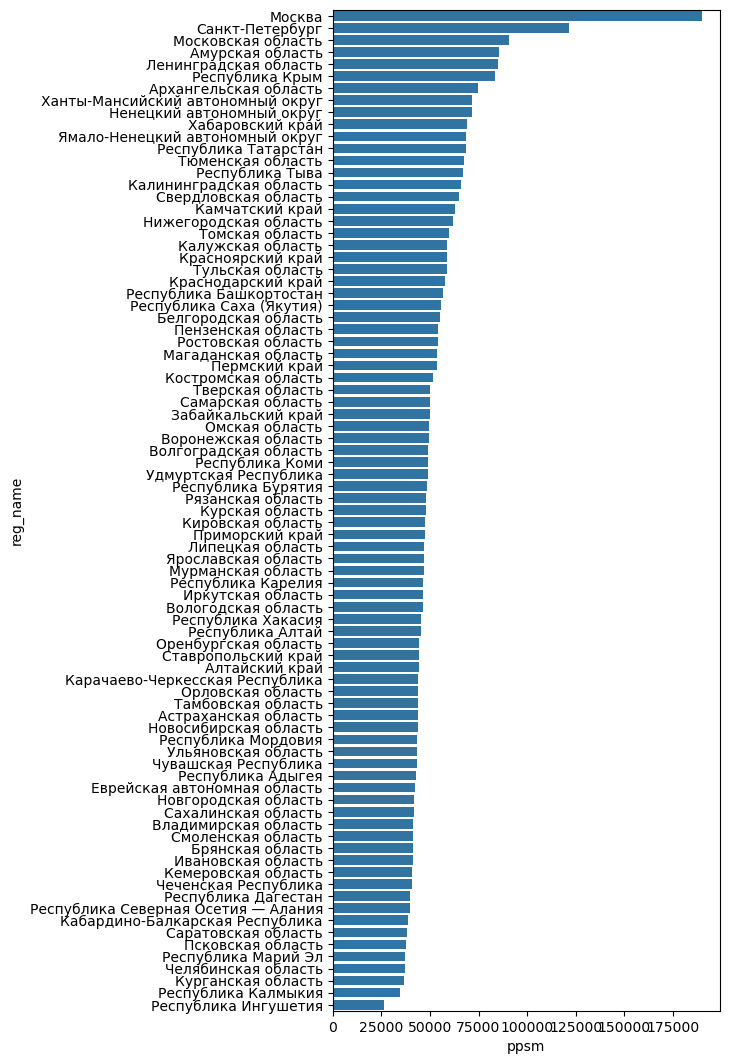

In [34]:
plt.figure(figsize=(5, 13))
sns.barplot(data = df.groupby(by = 'reg_name')['ppsm'].median().to_frame().sort_values(by = 'ppsm', ascending = False), y = 'reg_name', x = 'ppsm');

Медианная цена за квадратный метр вопросов и подозрений не вызывает. Рынок недвижимости в Москве и европейской части России перегрет многие годы, это выражает линейный график выше. Изучим данные на предмет аномалий.

In [35]:
df[df['price'] < 0].head(3)

,index,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,code,reg_name,ppsm
43797,43821,-1633967296,2018-09-14,5520,1,13,22,1,38.92,9.329238,1,5520,Пермский край,-41982715.7
43798,43822,-1633967296,2018-09-14,5520,1,14,22,1,38.92,17.260000,1,5520,Пермский край,-41982715.7
199366,199895,-429242296,2018-10-04,9654,2,5,25,2,57.27,9.310000,1,9654,Новосибирская область,-7495063.7


Удалим строчки с отрицательной ценой

In [36]:
df = df[~(df['price'] <= 0)]

Удалю те значения ppsm, что аномально малы. Ореинтировался на рынок вториной недвижимости в Воркуте (самые дешевые квартиры в России по росстату)

In [37]:
# Установим минимальный порог: возьмем значение 1% перцентиля
min_threshold = df['ppsm'].quantile(0.01)
df = df[df['ppsm'] > min_threshold]

print(f"Минимальное значение после фильтрации: {df['ppsm'].min()}")

Минимальное значение после фильтрации: 18077.8


Изучу прочее в рамках цены за квадратный метр

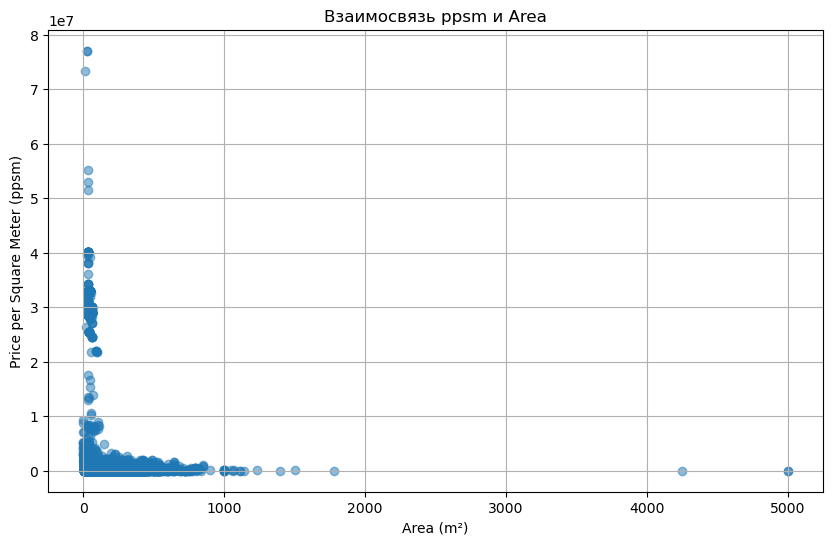

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(df['area'], df['ppsm'], alpha=0.5)
plt.title('Взаимосвязь ppsm и Area')
plt.xlabel('Area (m²)')
plt.ylabel('Price per Square Meter (ppsm)')
plt.grid(True)
plt.show()

Стало лучше. Данные выглядят реалистично с учетом специфики исследуемого рынка. Использую метод z-score и удалю оставшиеся данные, которые очевидно аномальны:

In [39]:
df['z_score'] = zscore(df['ppsm'])
z_outliers = df[df['z_score'].abs() > 3]
print(f"Количество оставшихся выбросов (по Z-оценкам): {len(df)}")

Количество оставшихся выбросов (по Z-оценкам): 5413473


In [40]:
df['z_score'] = zscore(df['ppsm'])
df = df[df['z_score'].abs() <= 4]
df = df.drop(columns=['z_score'])

print(f"Количество оставшихся данных: {len(df)}")

Количество оставшихся данных: 5412345


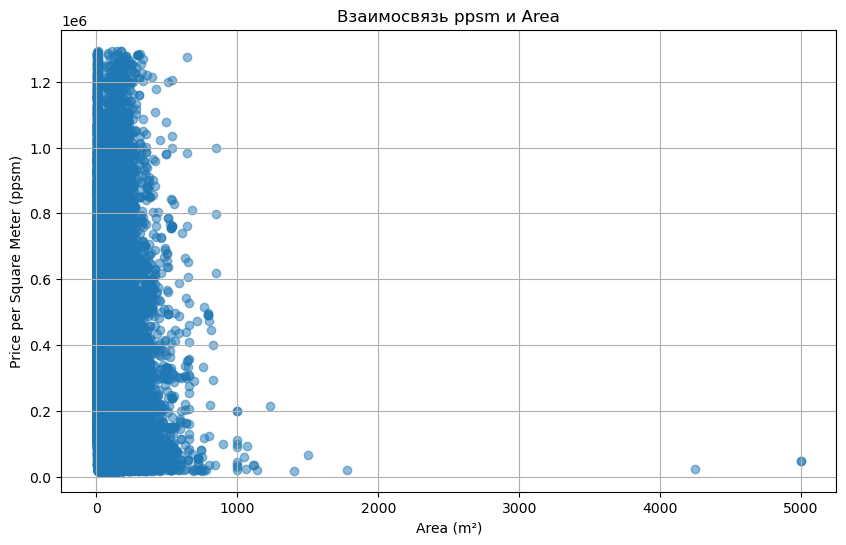

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(df['area'], df['ppsm'], alpha=0.5)
plt.title('Взаимосвязь ppsm и Area')
plt.xlabel('Area (m²)')
plt.ylabel('Price per Square Meter (ppsm)')
plt.grid(True)
plt.show()

Я согласен с тем, что график не содержит аномалий.   Видно, что большинство объектов с маленькой площадью (до 200 м²) имеют относительно высокую цену за квадратный метр (ppsm    Для больших объектов (площадь свыше 1000 м²) цена за квадратный метр заметно снижается, что подтверждает типичную закономерность на рынке недвижимости: крупные объекты чаще всего продаются дешевле за квадратный метр
Основная масса данных сконцентрирована в диапазон       
- area: 0–200 
- ppsm: 0–400,000/м².
Это ожидаемо, так как большинство объектов недвижимости относится к жилым квартирам и небольшиения)

Видно несколько объектов с:- Очень высокой ценой за м² (ppsm > 1,000,000 руб/м²), скорее всего, это элитная- мость.
- Большой площадью (до 5000 м²) — это могут быть коммерческие объекты, производственные здания.

После удаления выбросов по Z-оценке график выглядит логично: значения вписываются в типичное распределение для недвижимости.

### Когда выгодно покупать/продавать объект недвижимости? <a id="44"></a> [НАЗАД](#0)

Ввиду того, что рынок недвижимости очень многогранен и разнообразен, сложно рассматривать его как одно целое. Поэтому я разделю квартиры на несколько ценовых сегментов* и проведу сепарированный анализ:

- Эконом - до 1 000 000 р.
- Комфорт - от 3 до 5 млн.
- Бизннес - от 5 до 10 млн.
- Премиум - от 10 до 30 млн.
- Элитный - от 30 до 100 млн.
- Супер элитный - 100+ млн. р.

Деление на ценовые группы производилось в соответствии с новейшей классификацией Российской Гильдии Риэлторов (от 2023). Дополнительно был добавлен класс "Супер Люкс" для облегчения процесса анализа

In [42]:
def categorize_price(price):
    if price < 3000000:
        return "Очень дешевые"
    elif 3000000 <= price < 5000000:
        return "Дешевые"
    elif 5000000 <= price < 10000000:
        return "Средние"
    elif 10000000 <= price < 30000000:
        return "Дорогие"
    elif 30000000 <= price < 100000000:
        return "Люкс"
    else:
        return "Супер люкс"

df['segment'] = df['price'].apply(categorize_price)

Рассмотрим цены по каждой из категорий

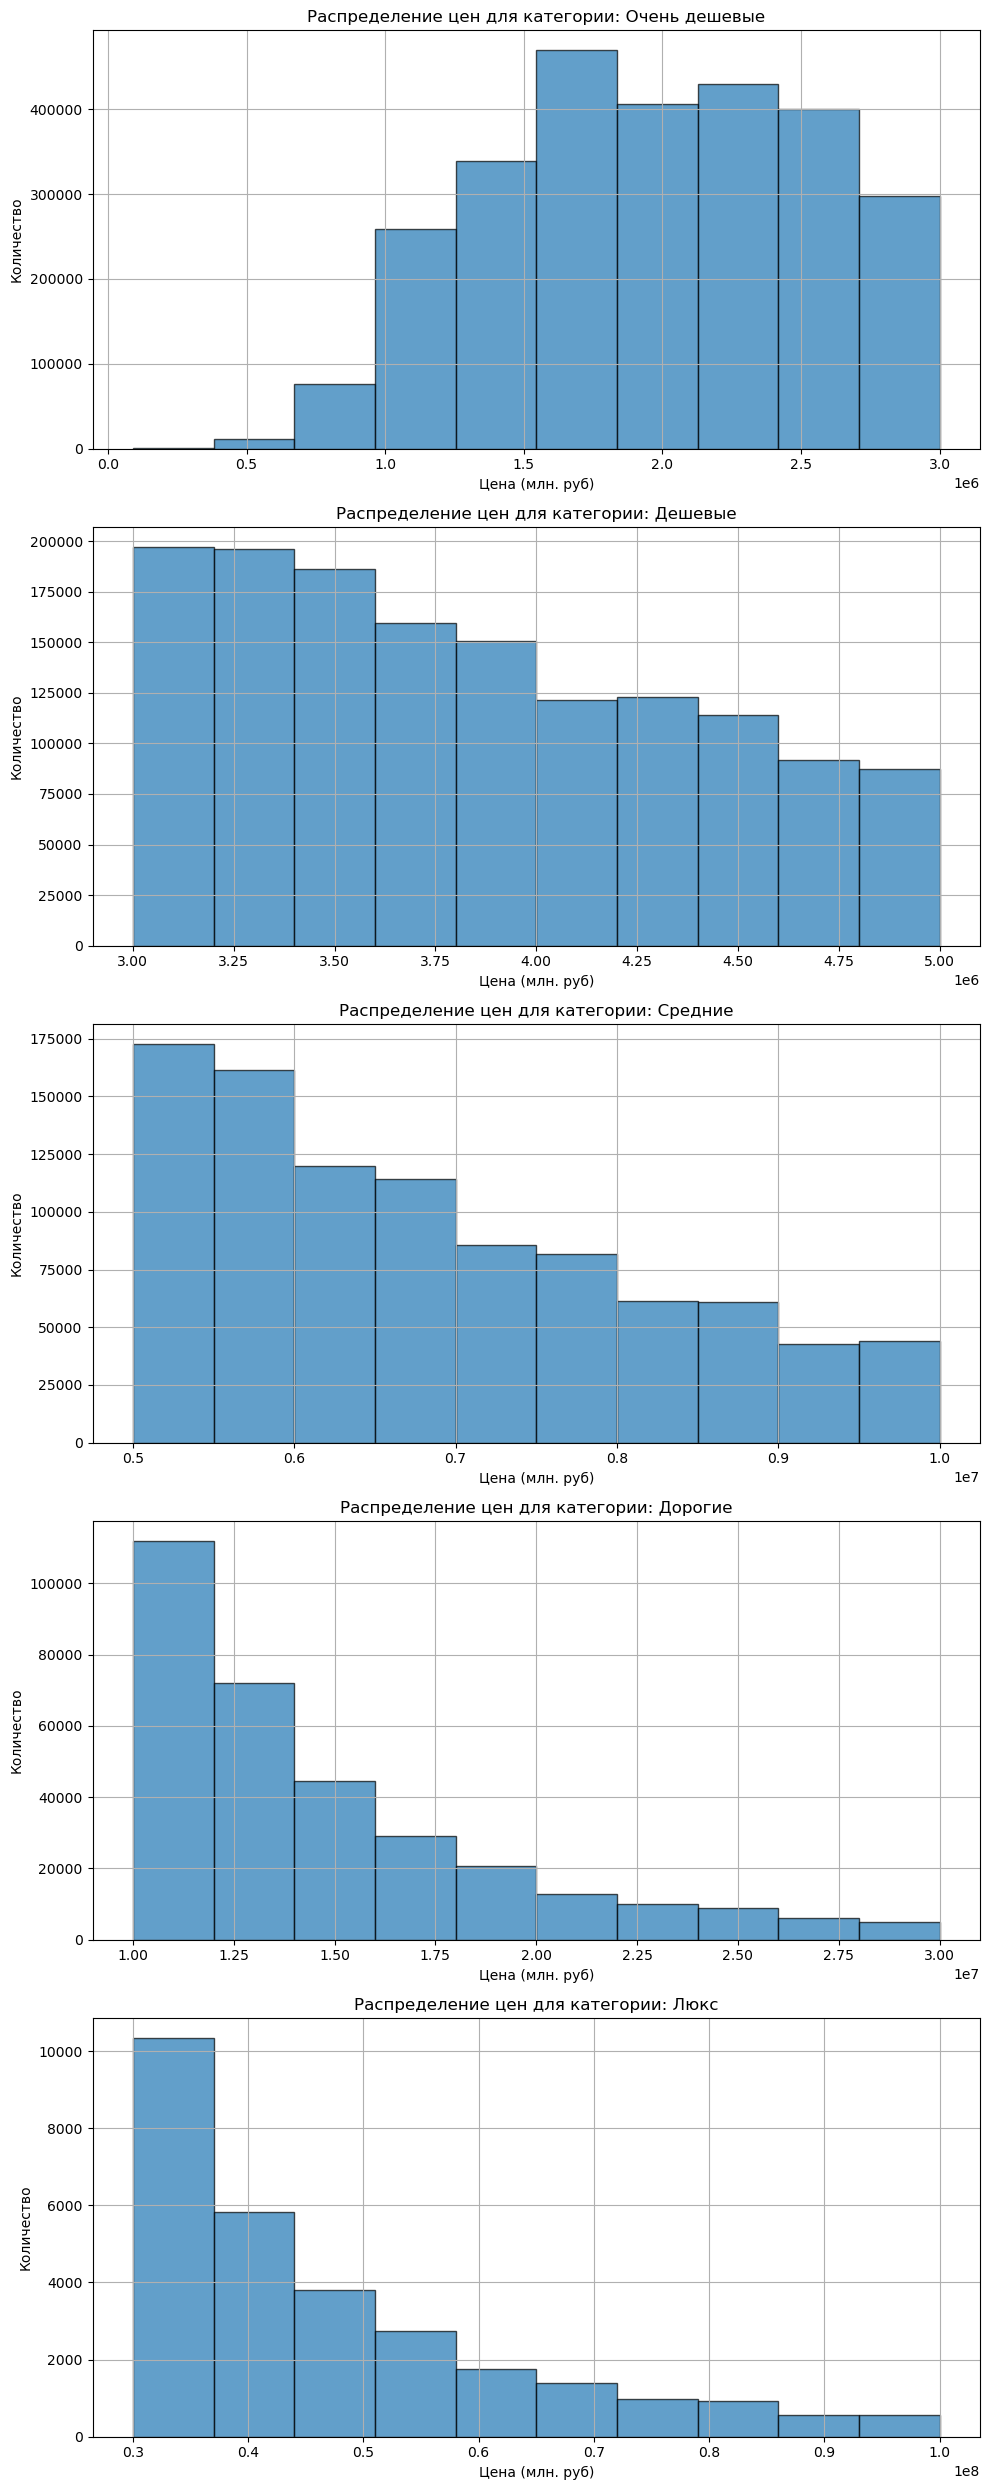

In [43]:
filtered_df = df[df['segment'] != "Супер люкс"]
filtered_segments = ['Очень дешевые', 'Дешевые', 'Средние', 'Дорогие', 'Люкс']

fig, axes = plt.subplots(len(filtered_segments), 1, figsize=(10, 5 * len(filtered_segments)))

for i, segment in enumerate(filtered_segments):
    segment_data = filtered_df[filtered_df['segment'] == segment]['price']
    axes[i].hist(segment_data, bins=10, alpha=0.7, edgecolor='black')
    axes[i].set_title(f"Распределение цен для категории: {segment}")
    axes[i].set_xlabel("Цена (млн. руб)")
    axes[i].set_ylabel("Количество")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Гистограммы по ценовым сегментам выглядят реалистично. После подъёма в сегменте сверхдешевой жилой площади заметен постепенный спад. Логично, что дорогих квартир относительно каждого отдельного сегмента меньше, чем средних по цене

In [44]:
df['date'] = pd.to_datetime(df['date']) 
df['date'] = df['date'].dt.strftime('%Y-%m')
df2 = df

Далее оценю медианные цены в каждой категрии домов в зависимости от времени объявления:

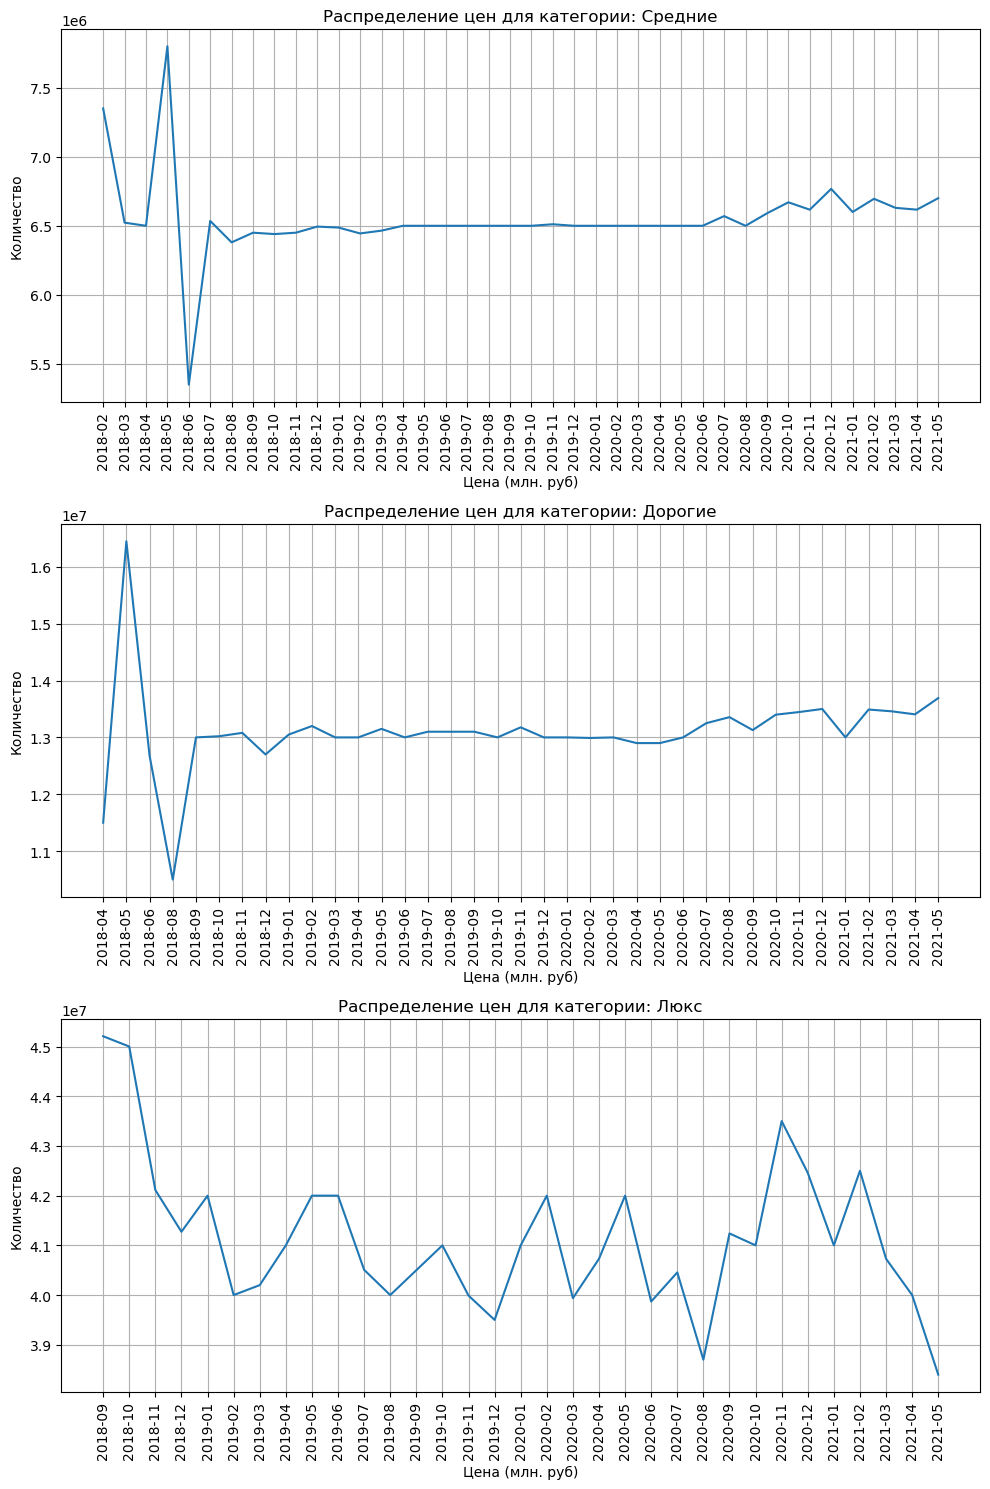

In [45]:
filtered_df = df[df['segment'] != "Супер люкс"]
filtered_segments = ['Средние', 'Дорогие', 'Люкс']

fig, axes = plt.subplots(len(filtered_segments), 1, figsize=(10, 5 * len(filtered_segments)))

for i, segment in enumerate(filtered_segments):
    segment_data = filtered_df[filtered_df['segment'] == segment]['price']
    axes[i].plot(df[df['segment'] == segment].groupby(by = 'date')['price'].median())
    axes[i].set_title(f"Распределение цен для категории: {segment}")
    axes[i].set_xlabel("Цена (млн. руб)")
    axes[i].set_ylabel("Количество")
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].grid(True)
    
plt.tight_layout()
plt.show();

Очень странная волатильность до 09-2018. Рассмотрю данные ПОСЛЕ этого периода

In [46]:
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

df = df[df['date'] >= pd.Timestamp('2018-09')]

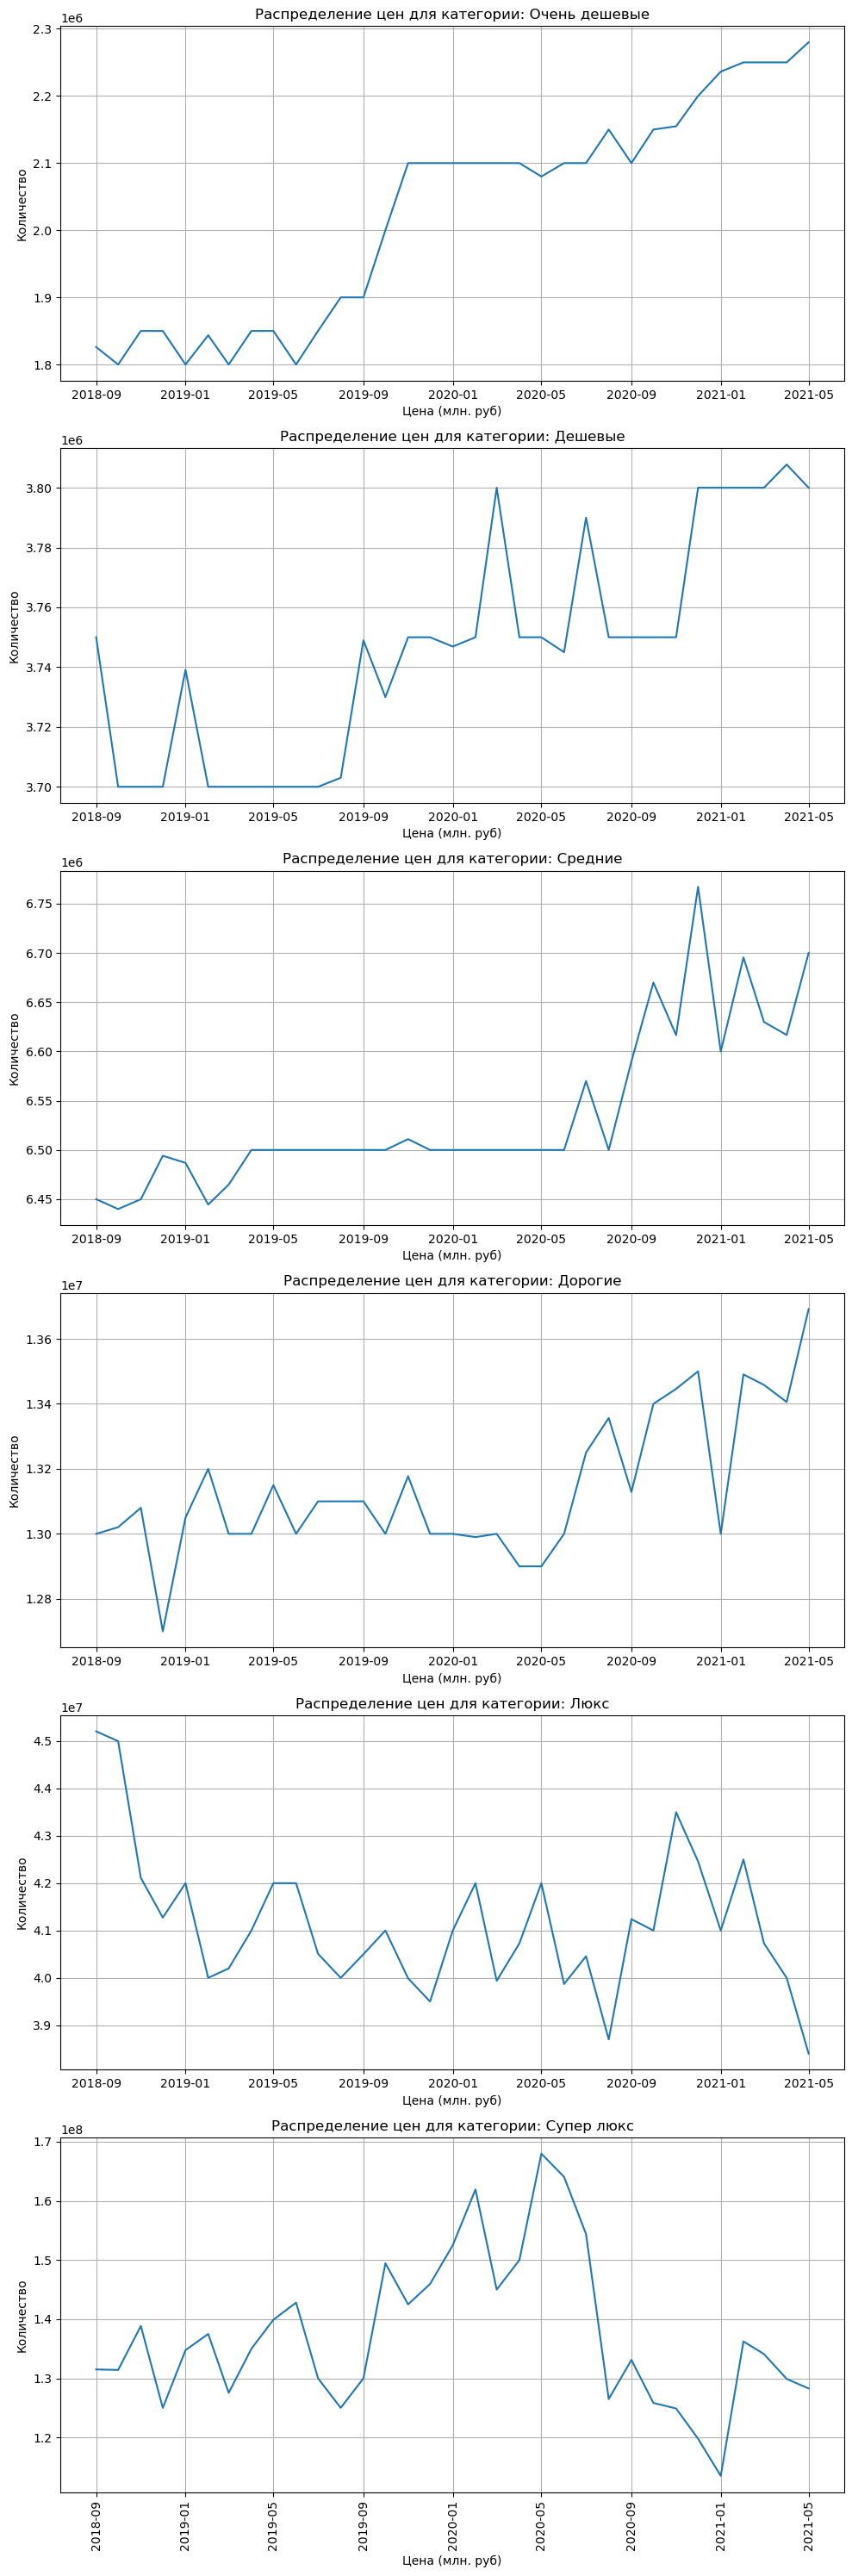

In [47]:
filtered_df = df[df['segment'] != "Супер люкс"]
filtered_segments = ['Очень дешевые', 'Дешевые', 'Средние', 'Дорогие', 'Люкс', 'Супер люкс']

fig, axes = plt.subplots(len(filtered_segments), 1, figsize=(10, 5 * len(filtered_segments)))
plt.xticks(rotation=90)

for i, segment in enumerate(filtered_segments):
    segment_data = filtered_df[filtered_df['segment'] == segment]['price']
    axes[i].plot(df[df['segment'] == segment].groupby(by = 'date')['price'].median())
    axes[i].set_title(f"Распределение цен для категории: {segment}")
    axes[i].set_xlabel("Цена (млн. руб)")
    axes[i].set_ylabel("Количество")
    axes[i].grid(True)
    
plt.tight_layout()
plt.show();

Теперь проведу статистические тесты. В них я определю лучшее время для покупки и, для проверки, проведу эмпирическое сравнение с графиками выше. Они должны совпасть

In [48]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].apply(get_season)

segments = ['Очень дешевые', 'Дешевые', 'Средние', 'Дорогие', 'Люкс', 'Супер люкс']

for segment in segments:
    print(f"\nАнализ для сегмента: {segment}")
    
    segment_data = df[df['segment'] == segment]
    
    season_groups = [segment_data[segment_data['season'] == season]['price'] for season in ['Зима', 'Весна', 'Лето', 'Осень']]
    
    # Проверяем, есть ли достаточно данных для теста
    if all(len(group) > 0 for group in season_groups):
        stat, p_value = kruskal(*season_groups)
        print(f"Статистика критерия Крускала-Уоллиса: {stat}")
        print(f"p-значение: {p_value}")
        
        alpha = 0.05
        if p_value < alpha:
            print("Есть статистически значимые различия в ценах между сезонами (отвергаем H0).")
            posthoc_results = posthoc_dunn(
                segment_data, 
                val_col='price', 
                group_col='season',  
                p_adjust='bonferroni'  
            )
            
            print("\nРезультаты пост-хок теста Данна (поправка Бонферрони):")
            print(posthoc_results)
            median_prices = segment_data.groupby('season')['price'].median().sort_values()
            best_season = median_prices.idxmin()
            print(f"Сезон с самой низкой медианной ценой: {best_season}")
        else:
            print("Нет статистически значимых различий в ценах между сезонами (не отвергаем H0).")
    else:
        print("Недостаточно данных для проведения теста в данном сегменте.")



Анализ для сегмента: Очень дешевые
Статистика критерия Крускала-Уоллиса: 801.7257680267124
p-значение: 1.827911417361519e-173
Есть статистически значимые различия в ценах между сезонами (отвергаем H0).

Результаты пост-хок теста Данна (поправка Бонферрони):
               Весна          Зима          Лето          Осень
Весна   1.000000e+00  1.540076e-17  1.151355e-69  2.736198e-156
Зима    1.540076e-17  1.000000e+00  3.467719e-20   2.025936e-67
Лето    1.151355e-69  3.467719e-20  1.000000e+00   8.720734e-11
Осень  2.736198e-156  2.025936e-67  8.720734e-11   1.000000e+00
Сезон с самой низкой медианной ценой: Лето

Анализ для сегмента: Дешевые
Статистика критерия Крускала-Уоллиса: 249.61081449972855
p-значение: 7.943312153400066e-54
Есть статистически значимые различия в ценах между сезонами (отвергаем H0).

Результаты пост-хок теста Данна (поправка Бонферрони):
              Весна          Зима          Лето         Осень
Весна  1.000000e+00  3.270790e-26  2.279639e-38  1.832157e-40
З

По результатам множественных тестов Крускала-Уоллиса, было выяснено, что выгоднее всего покупать:

- Очень дешевые квартивы - Летом
- Дешевые - Осенью
- Средние - Весной
- Дорогие - Зимой
- Люкс - Летом
- Супер Люкс - Зимой

Выводы подтверждаются эмпирическими наблюдениями на графиках цены по сегментам выше

### Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности. <a id="45"></a> [НАЗАД](#0)

In [49]:
df = df2
df.head(3)

,index,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,code,reg_name,ppsm,segment
0,0,6050000,2018-02-01,2661,1,8,10,3,82.6,10.8,2,2661,Санкт-Петербург,73244.6,Средние
1,1,8650000,2018-02-01,81,3,5,24,2,69.1,12.0,2,81,Московская область,125180.9,Средние
2,2,4000000,2018-02-01,2871,1,5,9,3,66.0,10.0,2,2871,Нижегородская область,60606.1,Дешевые


Построю матрицу корреляций. С её помощью я смог определить влияние определенных параметров на стоимость квартиры

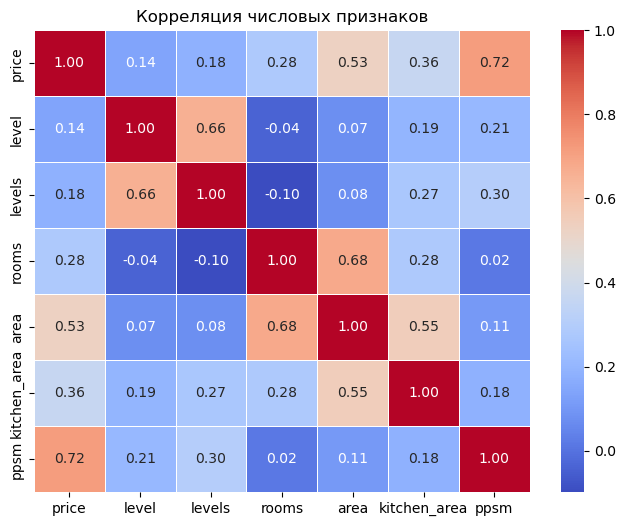

In [50]:
numerical_cols = ['price', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'ppsm']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Корреляция числовых признаков")
plt.show()

Ожидаемо, наибольший эффект на стоимость квартиры оказывает её площадь и цена за квадратный метр. Это ключевые признаки жилплощади. При том, из-за различий, которые будут рассмотрены мною далее, корреляция цены за квадратный метр и площади не стопроцентная.


Также важными признаками являются количество комнат и площадь кухни. Они имеют хоть сколько-то значимую связь с ценой.

Одним из таких признаков является показатель этажности и этажа. Построю графики медианных цен, чтобы оценить ситуацию в общем:

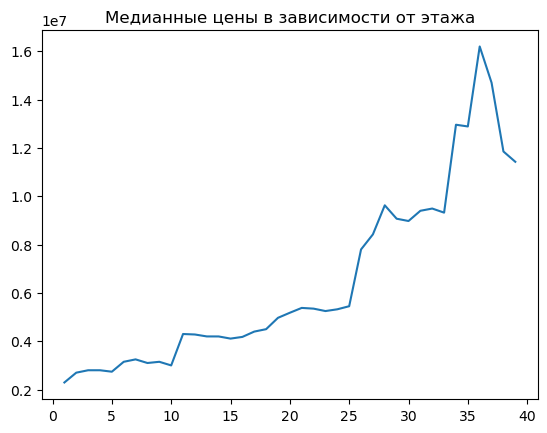

In [51]:
plt.title("Медианные цены в зависимости от этажа")
plt.plot(df.groupby(by = 'level')['price'].median());

В высоких зданиях высокие цены на жилье. В России их не так много, так что это либо Сталинки, либо квартиры в офисных небоскребах, либо квартиры в современных высоких комплексах. Люди готовы доплачивать за панорманый обзор на город.

Проведу аналогичный анализ для этажности

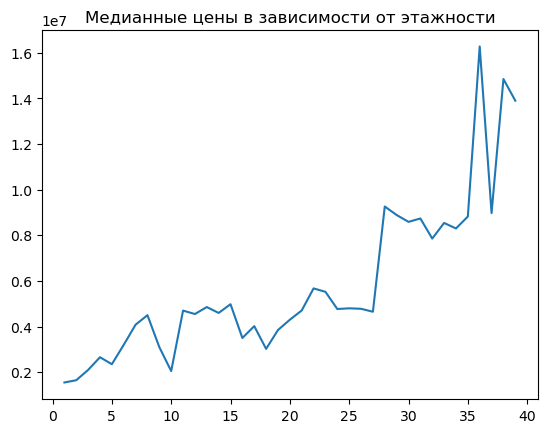

In [52]:
plt.title("Медианные цены в зависимости от этажности")
plt.plot(df.groupby(by = 'levels')['price'].median());

График близок с предыдущим. Заметны просадки цен на 5 и 10-этажные здания. Вероятно, это типовые советские жилые блоки. В высотках медианная стоимость квартир выше. Если бы мы брали среднее значение, читаемость портили бы дорогие особняки в 1-3 этажа

### Выдвинете и проверьте собственную гипотезу статистическими методами. <a id="46"></a> [НАЗАД](#0)

Во время исследования данных у меня возникла следующая гипотеза:

* Гипотеза H0: Отсутствует статистически значимая разница в стоимости объектов недвижимости на первом этаже многоэтажных домов и на последнем (самом верхнем)
* Гипотеза H1: Есть статистически значимая разница в стоимости объектов недвижимости на первом этаже многоэтажных домов и на последнем (самом верхнем)

In [53]:
df2 = df
df = df.query('levels != 1 and (level == levels or level == 1)')

In [54]:
def get_status(level):
    if level == 1:
        return 'first'
    else:
        return 'last'

df['status'] = df['level'].apply(get_status)

Проверю данные на равенство дисперсии и на основании этих данных проведу статистический тест:

In [55]:
df = df.sample(10000)

first_floor = df[df['status'] == 'first']['ppsm']
last_floor = df[df['status'] == 'last']['ppsm']

levene_test = stats.levene(first_floor, last_floor)
print("Тест на равенство дисперсий:", levene_test)

if levene_test.pvalue > 0.05:
    t_stat, p_value = stats.ttest_ind(first_floor, last_floor, equal_var=True)
else:
    t_stat, p_value = stats.ttest_ind(first_floor, last_floor, equal_var=False)

alpha = 0.05  # Уровень значимости

print("t-статистика:", t_stat)
print("p-значение:", p_value)

if p_value < alpha:
    print("Отвергаем H0: Есть статистически значимая разница в ценах между этажами.")
    mean_first = first_floor.mean()
    mean_last = last_floor.mean()
    
    if mean_first < mean_last:
        print("На первом этаже цена квадратного метра ниже (", round(mean_first, 2), "рублей).")
    else:
        print("На последнем этаже цена квадратного метра ниже (", round(mean_last, 2), "рублей).")
        
else:
    print("Не отвергаем H0: Нет статистически значимой разницы в ценах между этажами.")
df = df2

Тест на равенство дисперсий: LeveneResult(statistic=14.100621374916637, pvalue=0.00017426941158566516)
t-статистика: -4.341431618738486
p-значение: 1.4296612322587239e-05
Отвергаем H0: Есть статистически значимая разница в ценах между этажами.
На первом этаже цена квадратного метра ниже ( 62792.57 рублей).


По результатам тестирования было принято решение отвергнуть нулевую гипотезу H0 об отсутствии статистически значимой разницы в цене за квадратный метр на первом и на последнем этаже зданий. Вероятно, это связано с тем, что сейчас почти во всех домах стоят лифты (многократно продублированные) и люди предпочтут краивый вид и удалённость от шума города возможности быстро попавсть в квартиру и риску быть затопленными соседями сверху (особенно это может волновать тех, кто хочет сделать натяжные потолки, которые нынче в моде)

p-значение: 0.0 получено, так как Python использует стандарт IEEE 754 для представления чисел с плавающей запятой, и при выполнении математических операций с числами в очень большой отрицательной степени (-308), результат может стать настолько маленьким, что он будет округлен до 0, так как оно выходит за пределы точности.

### Создайте модель прогноза цены объекта недвижимости. <a id="47"></a> [НАЗАД](#0)

Далее создам модель для прогноза цен на недвижимость и оценю её точность

In [56]:
def encode_categorical(df):
    label_encoder = LabelEncoder()
    df['region'] = label_encoder.fit_transform(df['region'])
    df['building_type'] = label_encoder.fit_transform(df['building_type'])
    df['object_type'] = label_encoder.fit_transform(df['object_type'])
    return df

# Подготовка данных
def prepare_data(df):
    df = encode_categorical(df)
    
    X = df[['region', 'building_type', 'object_type', 'level', 'levels', 
            'rooms', 'area', 'kitchen_area', 'ppsm']]
    y = df['price']  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

    return X_train_sampled, X_test, y_train_sampled, y_test

# Построение и обучение модели
def train_model(X_train, y_train):
    train_data = lgb.Dataset(X_train, label=y_train)
    
    params = {
        'objective': 'regression',  
        'metric': 'rmse',           
        'boosting_type': 'gbdt',    
        'num_leaves': 31,           # Число листьев в дереве
        'learning_rate': 0.05,      # Скорость обучения
        'feature_fraction': 0.9,    
        'bagging_fraction': 0.8,    # Процент объектов для обучения
        'bagging_freq': 5,          
        'max_depth': -1,            
        'num_threads': -1           
    }
    
    # Обучение модели
    model = lgb.train(params, train_data, 1000) 
    return model

# Оценка модели
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    return rmse

# Основной код
X_train, X_test, y_train, y_test = prepare_data(df)
model = train_model(X_train, y_train)
rmse = evaluate_model(model, X_test, y_test)

print(f'Оценка качества модели(RMSE): {rmse}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 432987, number of used features: 9
[LightGBM] [Info] Start training from score 4385620.243310
Оценка качества модели(RMSE): 1569885.285543456


## Вывод <a id="5"></a> [НАЗАД](#0)

По результатам работы можно сдеелать ряд выводов о рынке недвижимости за предсавленный в датасете промежуток времени:

1) Самый дорогой рынок недвижимости в Москве, Санкт-Петербурге, их областях и в южных приморских ресубликах (Крым, Краснодар). Самый дешевый - в дотационных Кавказских республиках - в Чечне, Ингушетии и Кабардино-Балкарии.

2) В России распределение квартир по ценовым сегментам выглядит следующим образом:

    - Очень дешевые - 2689614;
    - Дешевые - 1413097
    - Средние - 870867
    - Дорогие - 302552
    - Люкс - 28862
    - Супер люкс - 3027
Довольно много дешевого и очень дешевого жилья (по сравнению с самыми дорогими регионами, конечно)

3) Большинство объектов с маленькой площадью (до 200 м²) имеют относительно высокую цену за квадратный метр (ppsm Для больших объектов (площадь свыше 1000 м²) цена за квадратный метр заметно снижается, что подтверждает типичную закономерность на рынке недвижимости: крупные объекты чаще всего продаются дешевле за квадратный метр. Основная масса данных сконцентрирована в диапазоне:

    - Площадь: 0–200
    - Цена за квадратны метр: 0–400,000/м².<br/><br/>
4) Ожидаемо, наибольший эффект на стоимость квартиры оказывает её площадь и цена за квадратный метр. Это ключевые признаки жилплощади. Также важными признаками являются количество комнат и площадь кухни. Они имеют хоть сколько-то значимую связь с ценой. Помимо этого, важными признаками являются количество комнат и площадь кухни. Они имеют хоть сколько-то значимую связь с ценой. В высоких зданиях высокие цены на жилье. В России их не так много, так что это либо Сталинки, либо квартиры в офисных небоскребах, либо квартиры в современных высоких комплексах. Люди готовы доплачивать за панорманый обзор на город.<br/><br/>
5) По результатам множественных тестов Крускала-Уоллиса, было выяснено, что выгоднее всего покупать:
    - Очень дешевые квартивы - Летом
    - Дешевые - Осенью
    - Средние - Весной
    - Дорогие - Зимой
    - Люкс - Летом
    - Супер Люкс - Зимой
<br/><br/>
6. По результатам тестирования было принято выявлено наличие статистически значимой разницы в цене за квадратный метр на первом и на последнем этаже зданий. Вероятно, это связано с тем, что сейчас почти во всех домах стоят лифты (многократно продублированные) и люди предпочтут краивый вид и удалённость от шума города возможности быстро попавсть в квартиру и риску быть затопленными соседями сверху (особенно это может волновать тех, кто хочет сделать натяжные потолки, которые нынче в моде)